In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import pickle
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [7]:
class DataExplorer:
    @staticmethod
    def explore_data(data: pd.DataFrame) -> None:
        '''
        Print general information of the DataFrame, first 5 rows, describe and info data, count for each column.

        Args:
            data: DataFrame to explore

        Returns:
            None 
        '''
        print(tabulate(data.head(), headers='keys', tablefmt='pretty'))
        print(tabulate(data.describe(include='all').T, headers='keys', tablefmt='pretty'))
        print(data.info())
        print(data.value_counts())

    @staticmethod
    def plot_histogram(data: pd.DataFrame, bins: int = 10) -> None:
        '''
        Plots the histogram for the numeric columns only.

        Args:
            data: DataFrame to plot

        Returns:
            None
        '''
        quantitative_columns = data.select_dtypes(include=np.number).columns
        ig, axes = plt.subplots(4, 4, figsize=(15,15)) # Creates subplots to show all the columns in a 4x4 matrix
        axes = axes.ravel()

        for column, ax in zip(quantitative_columns, axes):
            ax.set(title=f'{column.upper()} HISTOGRAM', xlabel=None)
            ax.tick_params(axis='y', labelsize=9)
            plot = sns.histplot(x=data[column], ax=ax, kde=True)
            ax.bar_label(ax.containers[0], fontsize=10)

            ax.yaxis.grid(True) # Hide the horizontal gridlines
            ax.xaxis.grid(False) # Show the vertical gridlines

        for i,ax in enumerate(axes): # Removes empty plot in subplots
            if(not ax.get_title()):
                ax.remove()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def count_plot(data: pd.DataFrame) -> None:
        '''
        Plots the count plot for the categorical columns only.

        Args:
            data: DataFrame to plot

        Returns:
            None
        '''
        categorical_columns = data.select_dtypes(include=object).columns
        ig, axes = plt.subplots(4, 4, figsize=(15,15)) # Creates subplots to show all the columns in a 4x4 matrix
        axes = axes.ravel()

        for column, ax in zip(categorical_columns, axes):
            ax.set(title=f'{column.upper()} COUNTPLOT', xlabel=None)
            ax.tick_params(axis='y', labelsize=9)
            ax.tick_params(axis='x', rotation=90)
            plot = sns.countplot(x=data[column], ax=ax)
            ax.bar_label(ax.containers[0], fontsize=10)

            ax.yaxis.grid(True) # Hide the horizontal gridlines
            ax.xaxis.grid(False) # Show the vertical gridlines

        for i,ax in enumerate(axes): # Removes empty plot in subplots
            if(not ax.get_title()):
                ax.remove()
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_correlation_matrix(data: pd.DataFrame) -> None:
        '''
        Plots the correlation matrix, this only applies to numeric values.

        Args:
            data: DataFrame to plot

        Returns:
            None
        '''
        quantitative_columns = data.select_dtypes(include=np.number).columns
        plt.figure(figsize=(12,8))
        sns.heatmap(data[quantitative_columns].corr(), annot=True, fmt='.2f')
        plt.show()

In [3]:
class KidneyRiskModel:
    def __init__(self, filepath: str, pipeline: Pipeline) -> None:
        self.filepath = filepath
        self.pipeline = pipeline
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4

    def load_data(self) -> None:
        self.data = pd.read_csv(self.filepath, header=0, skiprows=[1, 2])
        DataExplorer.explore_data(self.data)
        DataExplorer.plot_histogram(self.data)
        DataExplorer.count_plot(self.data)
        DataExplorer.plot_correlation_matrix(self.data)
        return self
    
    def preprocess_data(self, label_column: str) -> None:
        X = self.data.drop(columns=label_column)
        y = self.data[label_column].replace({'ckd':1, 'notckd':0}).infer_objects(copy=False)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        plt.subplot(1,3,1)
        self.y_train.value_counts().plot.pie(y=label_column, title='Proportion of each class for TRAIN set', figsize=(10,6))

        plt.subplot(1,3,3)
        self.y_test.value_counts().plot.pie(y=label_column, title='Proportion of each class for TEST set', figsize=(10,6))

        plt.tight_layout()
        plt.show()

        return self
    
    def train(self) -> None:
        self.pipeline.fit(self.X_train, self.y_train)
        return self
    
    def evaluate(self) -> None:
        y_hat = self.pipeline.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_hat)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(self.y_test))
        disp.plot()
        plt.show()

        report = classification_report(self.y_test, y_hat)
        print('Classification report:')
        print(report)
        return self
    
    def cross_validation(self, cv: int = 5) -> None:
        scores = cross_val_score(self.pipeline, self.X_train, self.y_train, cv=cv)
        print(f'Average Accuracy with Cross Valdiation: {np.mean(scores) * 100:.2f}%')
        return self
    
    def save_model(self, filename: str) -> None:
        '''
        Saves the mode as a pkl file

        Args:
            filename: string with the name of the pkl file

        Returns:
            None
        '''
        file_path = os.path.join('/home/chrisorduna/Repositories/MNA/MLOps_TC5044/models', filename)
        with open(file_path, 'wb') as f:
            pickle.dump(self.pipeline, f)
        return self
    
    def load_model(self, filename: str) -> None:
        file_path = os.path.join('/home/chrisorduna/Repositories/MNA/MLOps_TC5044/models', filename)
        with open(file_path, 'rb') as f:
            self.pipeline = pickle.load(f)

        return self

+---+----------------+----------+---------------+-------+-------+-----+-----+----+-----+----+-----------+-------------+-----------+--------+--------+-------------+-------------+-------------+---------------+-----+----+-----+-------+----+-----+-------------------+-------+----------+---------+
|   | bp (Diastolic) | bp limit |      sg       |  al   | class | rbc | su  | pc | pcc | ba |    bgr    |     bu      |    sod    |   sc   |  pot   |    hemo     |     pcv     |    rbcc     |     wbcc      | htn | dm | cad | appet | pe | ane |        grf        | stage | affected |   age   |
+---+----------------+----------+---------------+-------+-------+-----+-----+----+-----+----+-----------+-------------+-----------+--------+--------+-------------+-------------+-------------+---------------+-----+----+-----+-------+----+-----+-------------------+-------+----------+---------+
| 0 |       0        |    0     | 1.019 - 1.021 | 1 - 1 |  ckd  |  0  | < 0 | 0  |  0  | 0  |   < 112   |   < 48.1    | 1

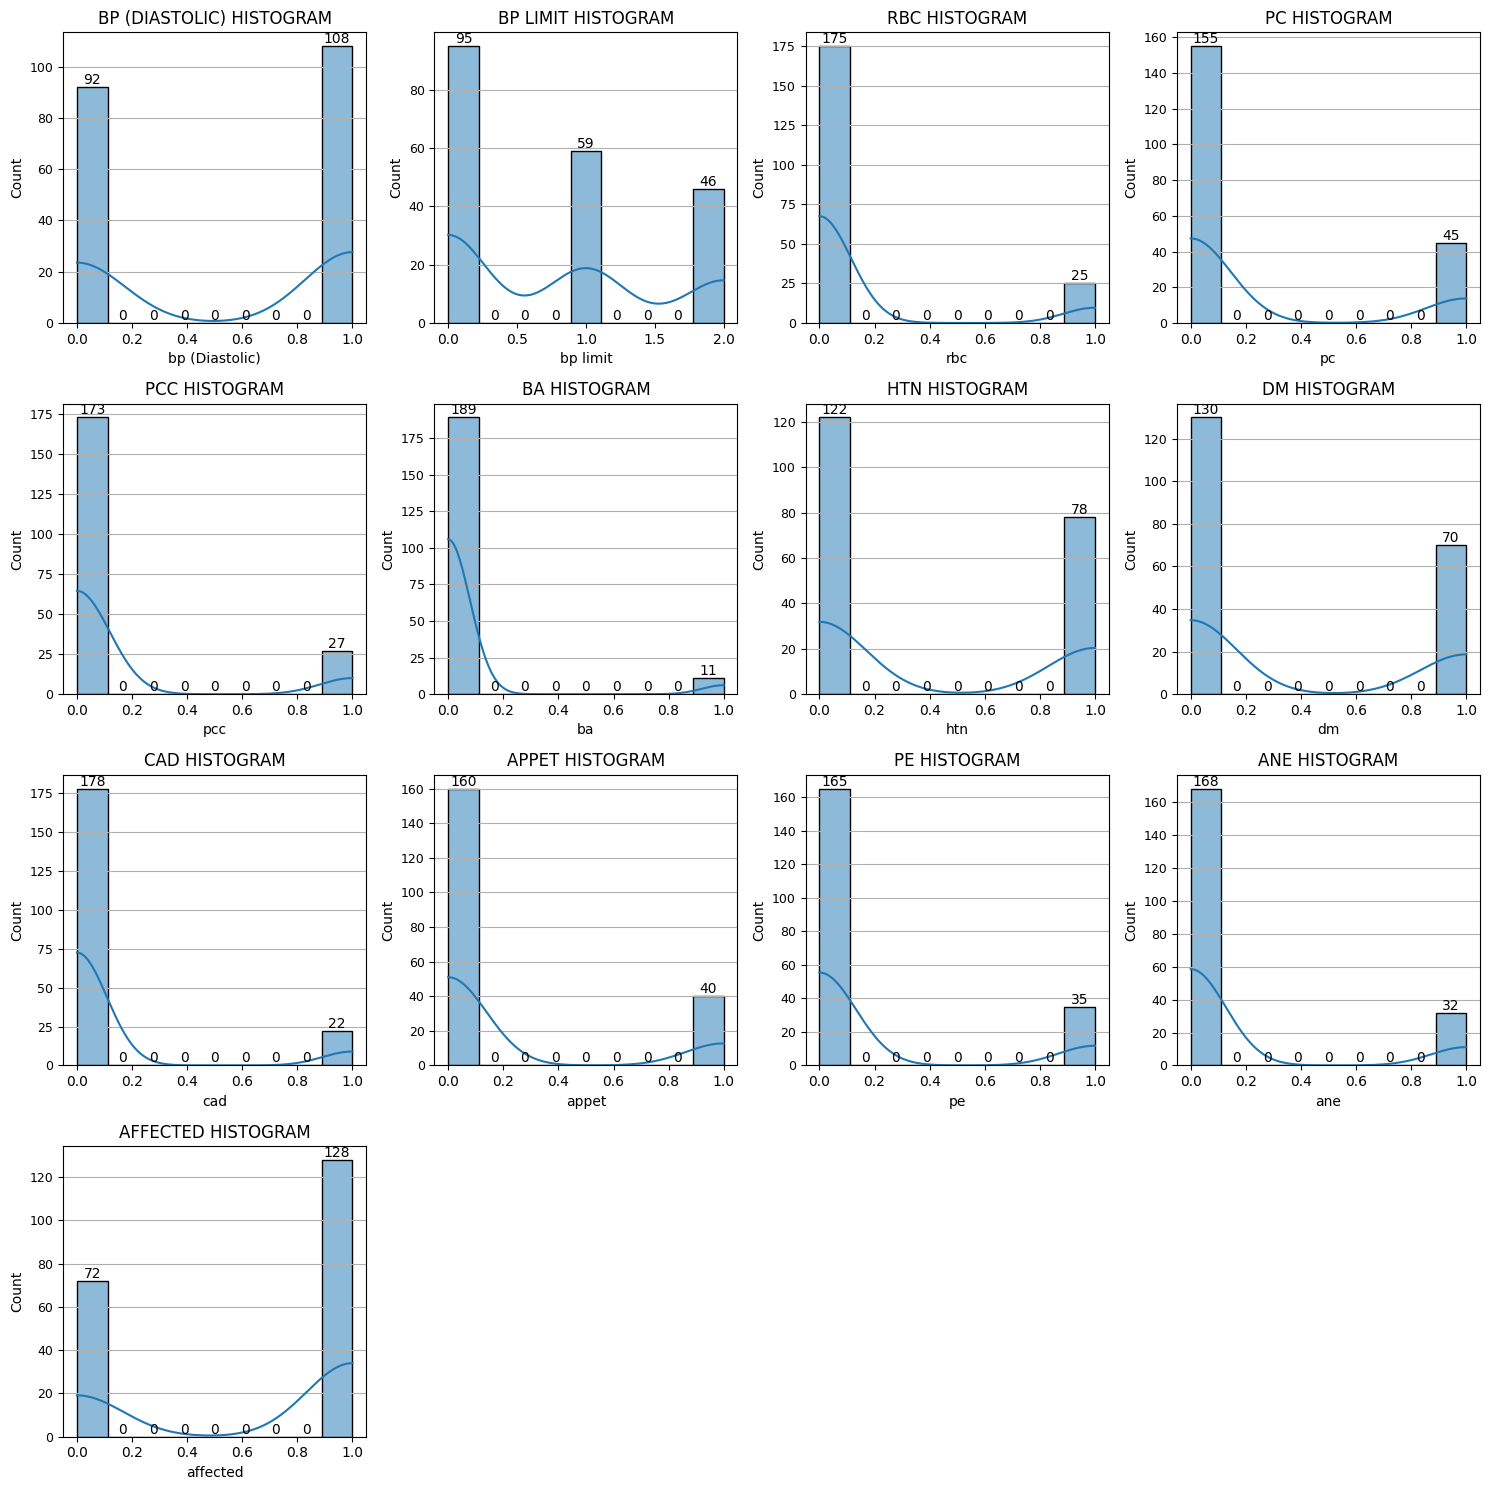

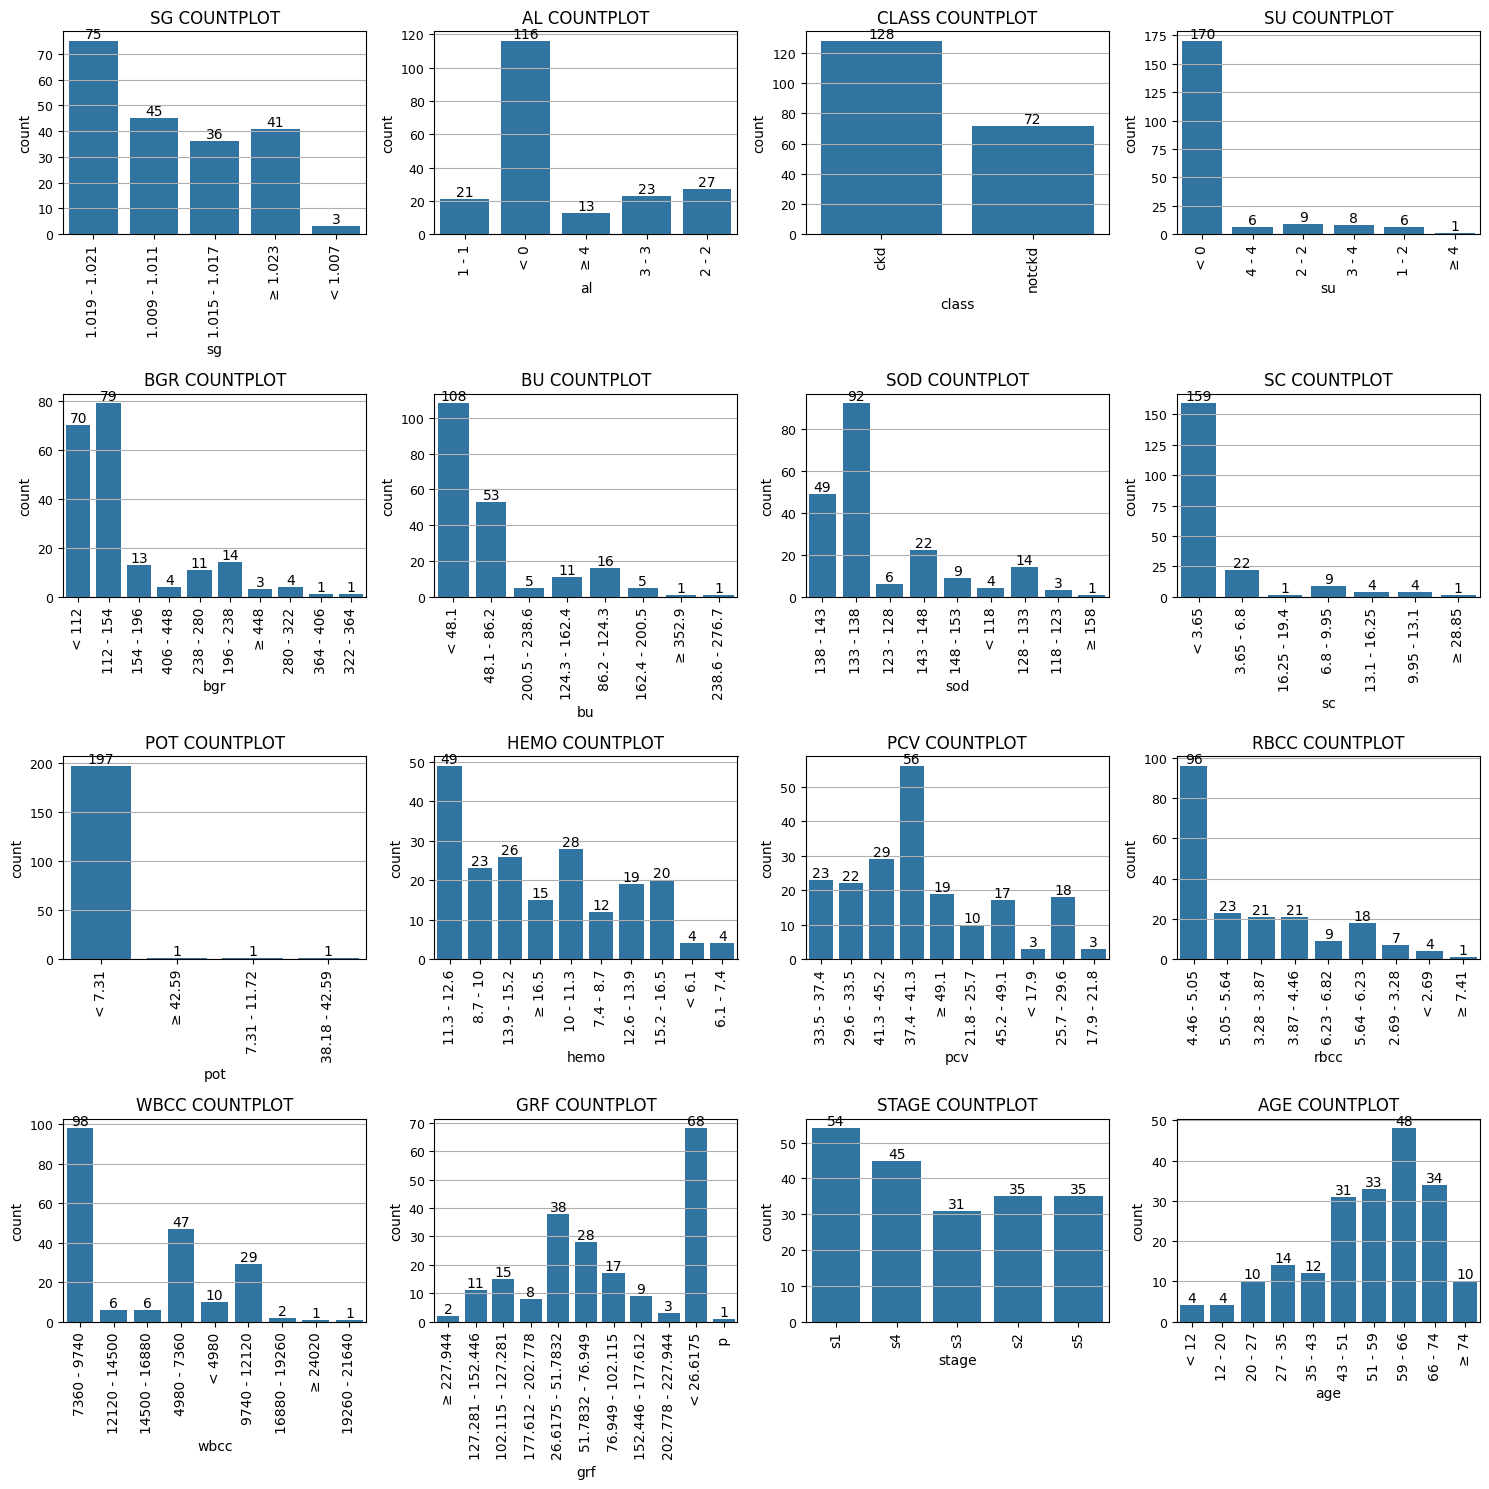

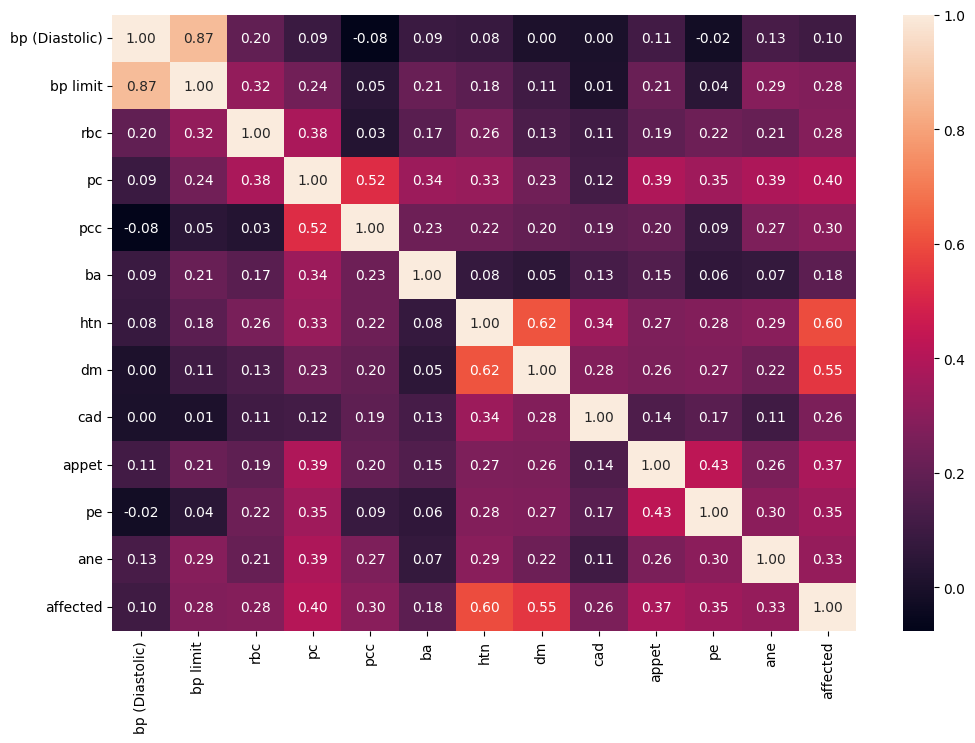

/tmp/ipykernel_6374/2802864613.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = self.data[label_column].replace({'ckd':1, 'notckd':0}).infer_objects(copy=False)
/home/chrisorduna/Repositories/MNA/.venv/mlops_venv3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


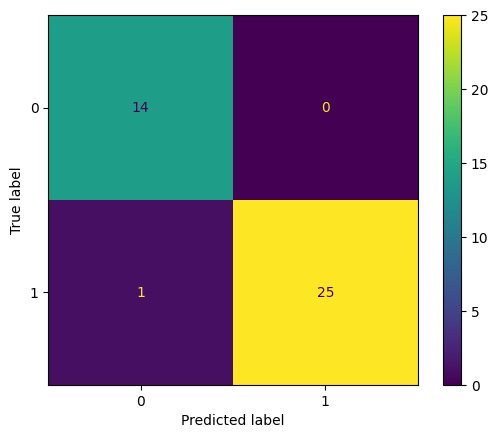

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.96      0.98        26

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40

Average Accuracy with Cross Valdiation: 98.75%


/home/chrisorduna/Repositories/MNA/.venv/mlops_venv3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/chrisorduna/Repositories/MNA/.venv/mlops_venv3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

In [8]:
filepath = '/home/chrisorduna/Repositories/MNA/MLOps_TC5044/data/raw/ckd-dataset-v2.csv'

categorical_columns = ['sg','al','su','bgr','bu','sod','sc','pot','hemo','pcv','rbcc','wbcc']

cat_pipeline = Pipeline(steps=[('ordinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

preprocessing = ColumnTransformer([
    ('categorical', cat_pipeline, categorical_columns)
])

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('standarization', StandardScaler()),
    ('logisticRegression', LogisticRegression(max_iter=10, random_state=41))
])

model = KidneyRiskModel(filepath=filepath, pipeline=pipeline)
model.load_data()
model.preprocess_data(label_column='class')
model.train()
model.evaluate()
model.cross_validation(cv=5)
model.save_model('lr_model.pkl')

## Adding PCA

In [ ]:
class PCAVarianceThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, variance_threshold: float = 0.9) -> None:
        self.variance_threshold = variance_threshold
        self.pca = None
    
    def fit(self, X: pd.DataFrame, y:pd.Series) -> None:
        self.pca = PCA().fit(X)
        cumulative_variance = np.cumsum(self.pca.explained_variance_ratio_)
        num_components = np.argmax(cumulative_variance >= self.variance_threshold)
        self.pca = PCA(num_components=num_components)
        self.pca.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame) -> np.ndarray:
        return self.pca.transform(X)

In [ ]:
pipeline_pca = Pipeline([
    ('preprocessing', preprocessing),
    ('standarization', StandardScaler()),
    ('pca', PCAVarianceThreshold(variance_threshold=0.90)),
    ('logisticRegression', LogisticRegression(max_iter=10, random_state=42))
])

model_pca = KidneyRiskModel(filepath=filepath, pipeline=pipeline)
model_pca.load_data()
model_pca.preprocess_data(label_column='class')
model_pca.train()
model_pca.evaluate()
model_pca.cross_validation(cv=5)
model_pca.save_model('lr_model_pca.pkl')